# Clustering 

Clustering concepts (algorithm, evaluation, and visualization) with  code and visual examples.


**What you'll cover:**
- Preprocessing for clustering
- K-Means (with elbow & silhouette analysis)
- Evaluating clusters 



## 1. Imports
If you don't have any, install them (scikit-learn, scipy, matplotlib, pandas).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, dendrogram

RANDOM_STATE = 42

## 2. Load datasets
We'll use the Iris dataset (real-world small dataset with labels for evaluation) and a synthetic blobs dataset (easy-to-visualize) to demonstrate strengths/limitations.

In [2]:
# Load Iris (contains true labels which we don't feed to the algorithms, but we use them for evaluation)
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names

# Create synthetic dataset with 4 blobs and some varying cluster variances
X_blobs, y_blobs = make_blobs(n_samples=500, centers=4, cluster_std=[0.6, 1.5, 0.4, 1.0], random_state=RANDOM_STATE)

print('Iris shape:', X_iris.shape)
print('Blobs shape:', X_blobs.shape)

Iris shape: (150, 4)
Blobs shape: (500, 2)


## 3. Preprocessing: scaling and optional PCA for visualization
Clustering is sensitive to feature scales (KMeans uses Euclidean distance). We scale features and then reduce to 2D with PCA for plots.

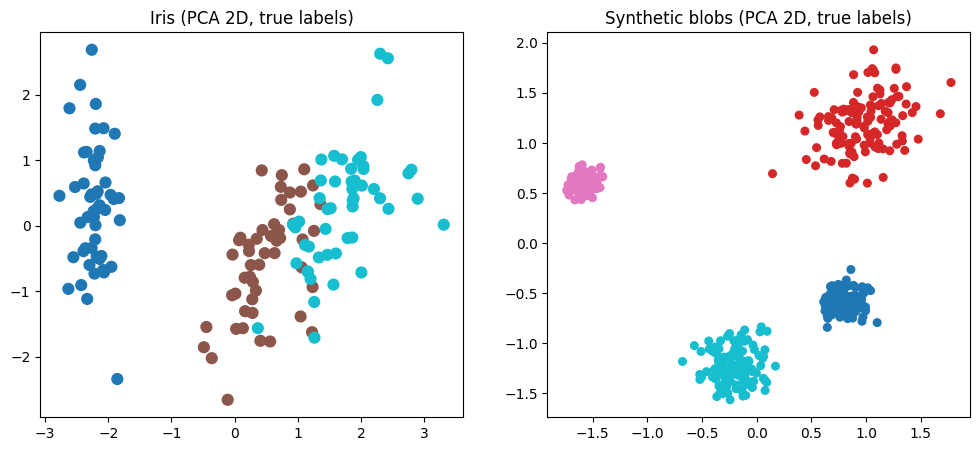

In [3]:
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
X_blobs_scaled = scaler.fit_transform(X_blobs)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_iris_2d = pca.fit_transform(X_iris_scaled)
X_blobs_2d = pca.fit_transform(X_blobs_scaled)

# Plot dataset (true labels only for demonstration)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, cmap='tab10', s=60)
axs[0].set_title('Iris (PCA 2D, true labels)')

axs[1].scatter(X_blobs_2d[:, 0], X_blobs_2d[:, 1], c=y_blobs, cmap='tab10', s=30)
axs[1].set_title('Synthetic blobs (PCA 2D, true labels)')
plt.show()

## 4. K-Means clustering
- Partition-based, minimizes within-cluster sum of squares.
- Needs `k` (number of clusters).
- Fast and simple, but assumes roughly spherical clusters of similar size.

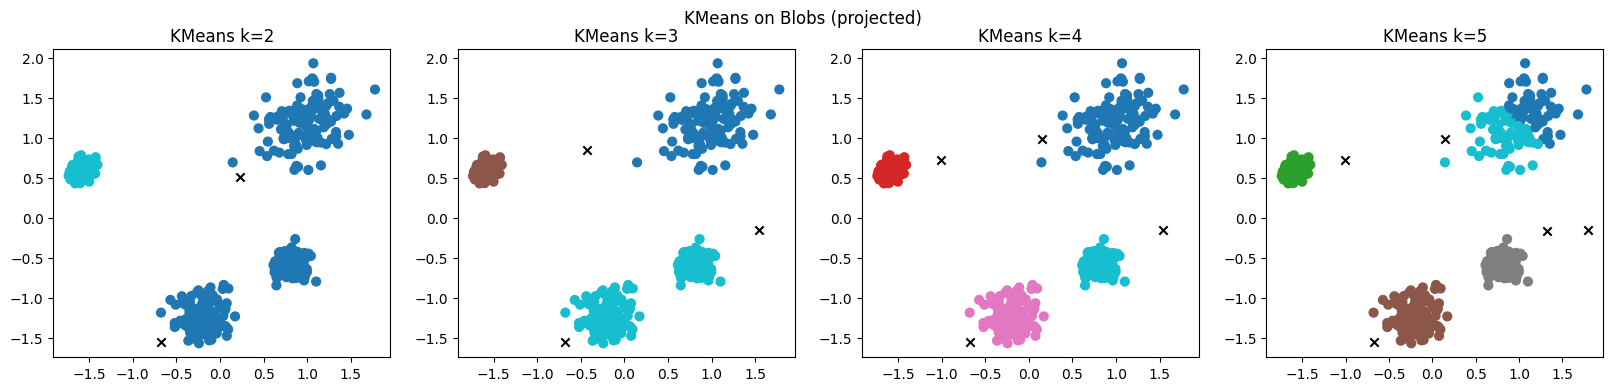

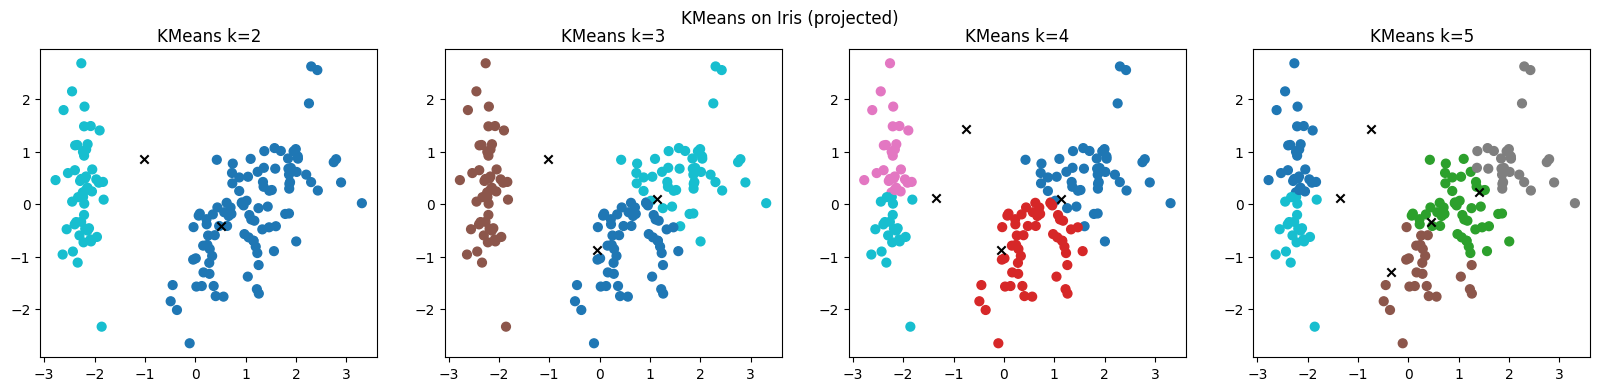

Iris KMeans silhouette scores:
 k=2: silhouette=0.5818
 k=3: silhouette=0.4599
 k=4: silhouette=0.3869
 k=5: silhouette=0.3459


In [4]:
# Helper: function to run KMeans and plot results in 2D PCA projection

def run_kmeans_and_plot(X_scaled, X_2d, ks=[2,3,4,5], dataset_name='dataset'):
    results = {}
    fig, axs = plt.subplots(1, len(ks), figsize=(5 * len(ks), 4))
    for i, k in enumerate(ks):
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(X_scaled)
        axs[i].scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=40)
        axs[i].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='k', marker='x')
        axs[i].set_title(f'KMeans k={k}')
        # Silhouette can be computed only when k > 1
        sil = silhouette_score(X_scaled, labels) if k > 1 else np.nan
        results[k] = {'labels': labels, 'silhouette': sil}
    fig.suptitle(f'KMeans on {dataset_name} (projected)')
    plt.show()
    return results

# Run on blobs (easy case)
kmeans_blobs = run_kmeans_and_plot(X_blobs_scaled, X_blobs_2d, ks=[2,3,4,5], dataset_name='Blobs')

# Run on Iris
kmeans_iris = run_kmeans_and_plot(X_iris_scaled, X_iris_2d, ks=[2,3,4,5], dataset_name='Iris')

# Print silhouette scores for Iris
print('Iris KMeans silhouette scores:')
for k, res in kmeans_iris.items():
    print(f' k={k}: silhouette={res["silhouette"]:.4f}')

### 5.1 Elbow method (choose k)
Compute SSE (inertia) for a range of k and look for an 'elbow'.

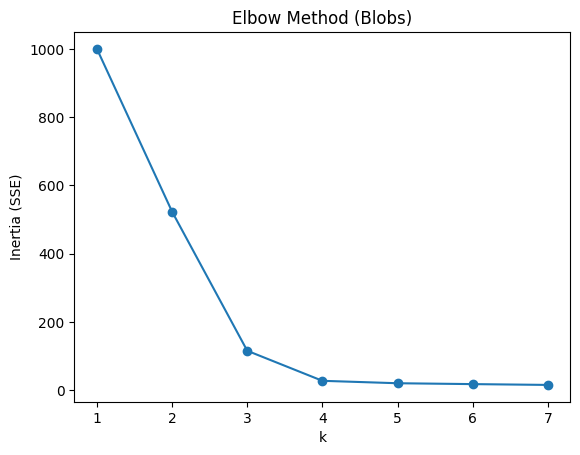

In [5]:
def elbow_method(X_scaled, k_range=range(1, 10)):
    inertias = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        km.fit(X_scaled)
        inertias.append(km.inertia_)
    return list(k_range), inertias

ks, inertias = elbow_method(X_blobs_scaled, range(1, 8))
plt.plot(ks, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method (Blobs)')
plt.xticks(ks)
plt.show()

## 6. Evaluation


In [6]:
# KMeans (k=3)
km = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
labels_km_iris = km.fit_predict(X_iris_scaled)

results = {
    'KMeans': labels_km_iris,
}

summary = []
for name, labels in results.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    sil = silhouette_score(X_iris_scaled, labels) if n_clusters > 1 else np.nan
    ari = adjusted_rand_score(y_iris, labels)
    summary.append({'method': name, 'n_clusters': n_clusters, 'silhouette': sil, 'ARI_vs_true': ari})

pd.DataFrame(summary)

,method,n_clusters,silhouette,ARI_vs_true
0,KMeans,3,0.459948,0.620135
